In [23]:
from elasticsearch import Elasticsearch
from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools

%matplotlib inline

In [24]:
es = Elasticsearch()
es

<Elasticsearch([{}])>

In [25]:
res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}})

In [26]:
def collect_all_results():
    res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}}, scroll='1m')
    scroll_id = res.get('_scroll_id')
    i = 1
    while scroll_id is not None:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id)
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
    return res
        

In [27]:
res = collect_all_results()

Processing scroll 1


# Total Associations

In [28]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

14750

In [29]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [30]:
count_attribute(res, 'source')

Counter({'cgi': 1429,
         'civic': 2713,
         'jax': 6513,
         'molecularmatch': 3116,
         'oncokb': 373,
         'pmkb': 606})

# Genes

In [31]:
%%capture
count_list_attribute(res, 'genes')

In [32]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [33]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({'cgi': 45, 'jax': 2492, 'molecularmatch': 215})

In [34]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [35]:
%%capture
mp_d

In [36]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [37]:
overlap(d)

cgi has 59/181 (32.60%) overlap with jax
cgi has 121/181 (66.85%) overlap with civic
cgi has 42/181 (23.20%) overlap with oncokb
cgi has 37/181 (20.44%) overlap with pmkb
cgi has 96/181 (53.04%) overlap with molecularmatch
cgi has 128/181 (70.72%) overlap overall
jax has 59/106 (55.66%) overlap with cgi
jax has 73/106 (68.87%) overlap with civic
jax has 30/106 (28.30%) overlap with oncokb
jax has 37/106 (34.91%) overlap with pmkb
jax has 64/106 (60.38%) overlap with molecularmatch
jax has 83/106 (78.30%) overlap overall
civic has 121/290 (41.72%) overlap with cgi
civic has 73/290 (25.17%) overlap with jax
civic has 42/290 (14.48%) overlap with oncokb
civic has 38/290 (13.10%) overlap with pmkb
civic has 140/290 (48.28%) overlap with molecularmatch
civic has 177/290 (61.03%) overlap overall
oncokb has 42/43 (97.67%) overlap with cgi
oncokb has 30/43 (69.77%) overlap with jax
oncokb has 42/43 (97.67%) overlap with civic
oncokb has 20/43 (46.51%) overlap with pmkb
oncokb has 41/43 (95.35%

In [38]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'])

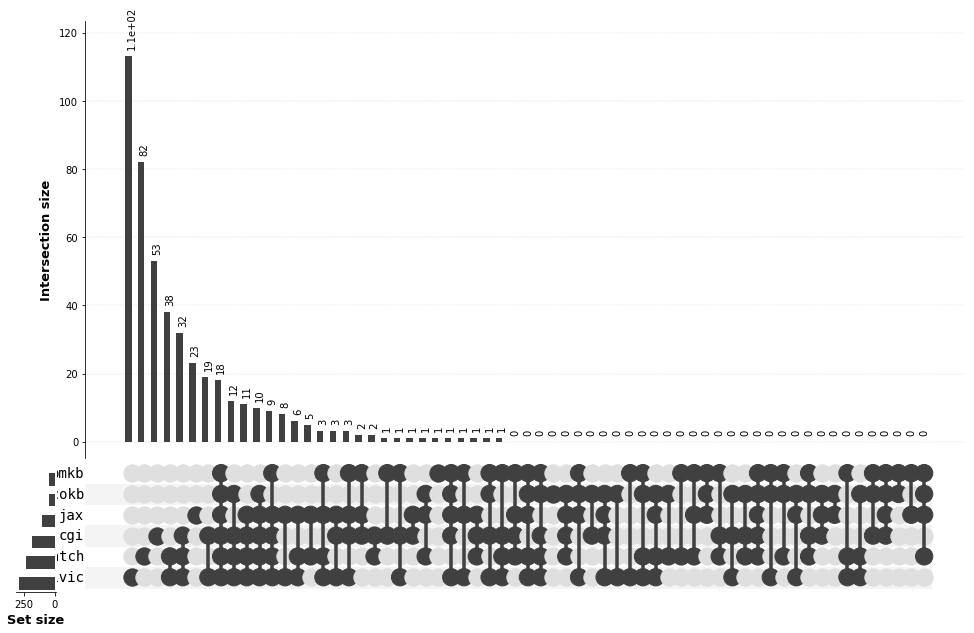

In [39]:
plot_overlap(d)

# Overlap of associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [40]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{'description': 'Imatinib',
  'id': 'compound:CID5291',
  'term': 'Imatinib',
  'toxicity': 'The most frequently reported adverse reactions (>30%) were edema, nausea,\r\nvomiting, muscle cramps, musculoskeletal pain, diarrhea, rash, fatigue and\r\nabdominal pain.'},
 {'description': 'inhibitor',
  'id': 'compound:CID657356',
  'term': 'inhibitor',
  'toxicity': 'unknown'},
 {'description': 'Clorazepate Dipotassium',
  'id': 'compound:CID23706210',
  'term': 'Clorazepate Dipotassium',
  'toxicity': 'unknown'}]

"Inhibitor" drug: https://pubchem.ncbi.nlm.nih.gov/compound/diacylglycerol_kinase_inhibitor_ii#section=Top

In [41]:
res['hits']['hits'][0]['_source']['cgi']

{'Alteration': 'ABL1:I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P,V371A,E373K,V379I,A380T,F382L,L384M,L387M,L387F,L387V,M388L,Y393C,H396P,H396R,H396A,A397P,S417F,S417Y,I418S,I418V,A433T,S438C,E450K,E450G,E450A,E450V,E453K,E453G,E453A,E453V,E459K,E459G,E459A,E459V,M472I,P480L,F486S,E507G',
 'Alteration type': 'MUT',
 'Assay type': '',
 'Association': 'Resistant',
 'Biomarker': 'ABL1 (I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P

In [42]:
def select_failures(hits):
    pheno_failed = 0
    drug_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            gene = ''
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            print( "Drug failure on ID {}".format( hit['_id'] ))
            drug_failed += 1
            drug = None
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if drug is None or phenotype is None:
            yield(hit)
        # yield (gene,drug,phenotype)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} hits with failed drug'.format(drug_failed))
    print('{} total hits'.format(len(hits)))

In [43]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [44]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

42.73% of associations not fully normalized across gene, drug, phenotype


In [45]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 894,
         'civic': 76,
         'jax': 1825,
         'molecularmatch': 2851,
         'oncokb': 51,
         'pmkb': 606})

In [46]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '62.56%',
 'civic': '2.80%',
 'jax': '28.02%',
 'molecularmatch': '91.50%',
 'oncokb': '13.67%',
 'pmkb': '100.00%'}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [47]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

{'description': 'KIT(cKIT) mutations are present in approximatley 8-25% of cases of acute myeloid leukemia and  have a higher prevalence in the favorable cytogenetic risk group (t(8;21)(q22;q22)(RUNX1-RUNX1T1),  inv(16)(p13q22)(CBFB-MYH11) or normal karyotype.   Mutations of KIT in AML are  most common in KIT exon 17 (within the activation loop of the tyrosine kinase domain) but may also occur in KIT exons 8(extracellular portion of the receptor implicated in dimerization), 9-11 (juxtamembrane/transmembrane domains).  The presence of KIT mutations in patients with t(8;21)(q22;q22)(RUNX1-RUNX1T1) has been reported to be associated with a  poorer survival than expected for patients with the  t(8;21)(q22;q22) who do not carry a KIT mutation; however, on the other hand, several published studies have not shown an effect on survival/outcome.   KIT mutations are also important in systemic mastocytosis  and various mast cell disorders;  over 90% of cases of systemic mastocytosis carry mutatio

In [48]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

False

# Overlap of associations (gene + phenotype)

In [49]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            gene = ''
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [50]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [51]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

37.15% of associations not fully normalized across gene, phenotype


In [52]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 859,
         'civic': 49,
         'jax': 1576,
         'molecularmatch': 2821,
         'oncokb': 32,
         'pmkb': 142})

In [53]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '60.11%',
 'civic': '1.81%',
 'jax': '24.20%',
 'molecularmatch': '90.53%',
 'oncokb': '8.58%',
 'pmkb': '23.43%'}

Prostate Adenocarcinoma?

In [54]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

{'description': 'ALK novel ALK inhibitors Responsive',
 'drug_labels': 'alanylleucyllysine',
 'environmentalContexts': [{'description': 'alanylleucyllysine',
   'id': 'compound:CID18411393',
   'term': 'alanylleucyllysine'}],
 'evidence': [{'description': 'Responsive',
   'evidenceType': {'sourceName': 'cgi'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/23639470']}}],
 'evidence_label': 'D',
 'phenotype': {'description': 'LUAD'},
 'publication_url': 'http://www.ncbi.nlm.nih.gov/pubmed/23639470',
 'response_type': 'Responsive'}

In [55]:
cgi[0]['_source']['cgi']

{'Alteration': 'ALK__.',
 'Alteration type': 'FUS',
 'Assay type': '',
 'Association': 'Responsive',
 'Biomarker': 'ALK fusion',
 'Curator': 'RDientsmann',
 'Drug': '[]',
 'Drug family': '[novel ALK inhibitor]',
 'Drug full name': 'novel ALK inhibitors',
 'Drug status': '',
 'Evidence level': 'Early trials',
 'Gene': 'ALK',
 'Metastatic Tumor Type': '',
 'Primary Tumor type': 'LUAD',
 'Source': 'PMID:23639470',
 'Targeting': '',
 'cDNA': '',
 'gDNA': '',
 'gene': '',
 'individual_mutation': '',
 'info': '',
 'region': '',
 'strand': '',
 'transcript': ''}

In [56]:
%%capture
set([x['_source']['association']['phenotype']['description'] for x in cgi])

In [57]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
            hit['merged'] = {'gene': gene}
        except:
            hit['merged'] = {'gene': ''}
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged']['phenotype'] = phenotype
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [58]:
%%capture
successes = list(select_successes(res['hits']['hits']))

In [59]:
s = Counter([x['_source']['source'] for x in successes])
s

Counter({'cgi': 570,
         'civic': 2664,
         'jax': 4937,
         'molecularmatch': 295,
         'oncokb': 341,
         'pmkb': 464})

In [60]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [61]:
%%capture
success_by_source

In [62]:
overlap(success_by_source)

cgi has 14/105 (13.33%) overlap with jax
cgi has 26/105 (24.76%) overlap with civic
cgi has 9/105 (8.57%) overlap with oncokb
cgi has 6/105 (5.71%) overlap with pmkb
cgi has 0/105 (0.00%) overlap with molecularmatch
cgi has 28/105 (26.67%) overlap overall
jax has 14/832 (1.68%) overlap with cgi
jax has 175/832 (21.03%) overlap with civic
jax has 37/832 (4.45%) overlap with oncokb
jax has 34/832 (4.09%) overlap with pmkb
jax has 7/832 (0.84%) overlap with molecularmatch
jax has 201/832 (24.16%) overlap overall
civic has 26/756 (3.44%) overlap with cgi
civic has 175/756 (23.15%) overlap with jax
civic has 32/756 (4.23%) overlap with oncokb
civic has 34/756 (4.50%) overlap with pmkb
civic has 4/756 (0.53%) overlap with molecularmatch
civic has 206/756 (27.25%) overlap overall
oncokb has 9/68 (13.24%) overlap with cgi
oncokb has 37/68 (54.41%) overlap with jax
oncokb has 32/68 (47.06%) overlap with civic
oncokb has 9/68 (13.24%) overlap with pmkb
oncokb has 0/68 (0.00%) overlap with molecu

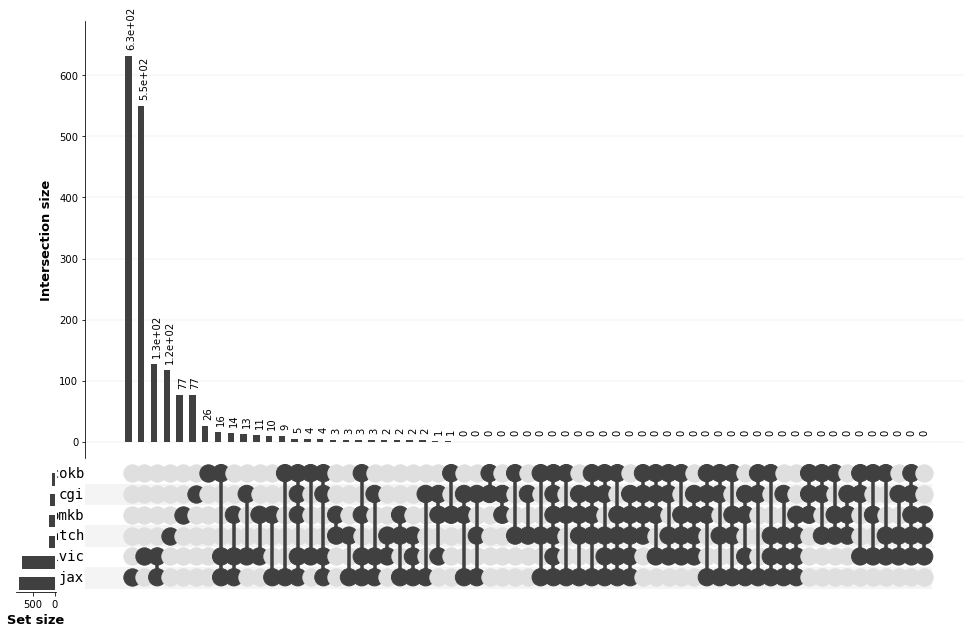

In [63]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])


## Finding gene-PMID associations and comparing to gene-phenotype

This is some debugging code for issue 41: https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41

In [64]:
double_listed_refs = Counter()
single_listed_refs = Counter()

listed_evidence = Counter()
single_evidence = Counter()
for hit in res['hits']['hits']:
    if isinstance(hit['_source']['association']['evidence'], list):
        listed_evidence[hit['_source']['source']] += 1
        for evidence in hit['_source']['association']['evidence']:
            for pmid_url in evidence['info']['publications']:
                if isinstance(pmid_url, list):
                    double_listed_refs[hit['_source']['source']] += 1
                else:
                    single_listed_refs[hit['_source']['source']] += 1
    else:
        single_evidence[hit['_source']['source']] += 1
        evidence = hit['_source']['association']['evidence']
        for pmid_url in evidence['info']['publications']:
            if isinstance(pmid_url, list):
                double_listed_refs[hit['_source']['source']] += 1
            else:
                single_listed_refs[hit['_source']['source']] += 1

In [65]:
print(double_listed_refs)
print(single_listed_refs)
print(listed_evidence)
print(single_evidence)

Counter({'jax': 6513, 'pmkb': 606, 'oncokb': 373})
Counter({'molecularmatch': 5172, 'civic': 2713, 'cgi': 1859})
Counter({'jax': 6513, 'molecularmatch': 3116, 'cgi': 1429, 'pmkb': 606, 'oncokb': 373})
Counter({'civic': 2713})


First, we'll look at just PMID overlap

In [66]:
pmid_re = re.compile(r'https?://www.ncbi.nlm.nih.gov/pubmed/(\d+)')
source_pmids = defaultdict(set)
single_url = Counter()
listed_url = Counter()
for hit in res['hits']['hits']:
    pmids = set()
    # next two lines fix double_listing, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
    if not isinstance(hit['_source']['association']['evidence'], list):
        hit['_source']['association']['evidence'] = [hit['_source']['association']['evidence']]
    for evidence in hit['_source']['association']['evidence']:
        urls = evidence['info']['publications']
    # next two lines fix single_evidence, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
        if isinstance(urls[0], list):
            urls = itertools.chain.from_iterable(urls)
        for pmid_url in urls:
            match = pmid_re.match(pmid_url)
            if match:
                pmids.add(match.groups()[0])
    urls = hit['_source']['association'].get('publication_url')
    # the following lines document differences in the structure of the publication_url field
    if not isinstance(urls, list):
        single_url[hit['_source']['source']] += 1
        urls = [urls]
    else:
        listed_url[hit['_source']['source']] += 1
    for url in urls:
        if url is None:
            continue
        match = pmid_re.match(url)
        if match:
            pmids.add(match.groups()[0])
    source_pmids[hit['_source']['source']] |= pmids
    pmids = list(pmids)
    if 'merged' in hit:
        hit['merged']['pmids'] = pmids
    else:
        hit['merged'] = {'pmids': pmids}
    

In [67]:
{k: len(v) for k, v in source_pmids.items()}

{'cgi': 566,
 'civic': 1431,
 'jax': 1334,
 'molecularmatch': 936,
 'oncokb': 76,
 'pmkb': 335}

In [68]:
overlap(source_pmids)

cgi has 135/566 (23.85%) overlap with jax
cgi has 158/566 (27.92%) overlap with civic
cgi has 21/566 (3.71%) overlap with oncokb
cgi has 15/566 (2.65%) overlap with pmkb
cgi has 137/566 (24.20%) overlap with molecularmatch
cgi has 262/566 (46.29%) overlap overall
jax has 135/1334 (10.12%) overlap with cgi
jax has 217/1334 (16.27%) overlap with civic
jax has 15/1334 (1.12%) overlap with oncokb
jax has 32/1334 (2.40%) overlap with pmkb
jax has 208/1334 (15.59%) overlap with molecularmatch
jax has 363/1334 (27.21%) overlap overall
civic has 158/1431 (11.04%) overlap with cgi
civic has 217/1431 (15.16%) overlap with jax
civic has 27/1431 (1.89%) overlap with oncokb
civic has 36/1431 (2.52%) overlap with pmkb
civic has 619/1431 (43.26%) overlap with molecularmatch
civic has 735/1431 (51.36%) overlap overall
oncokb has 21/76 (27.63%) overlap with cgi
oncokb has 15/76 (19.74%) overlap with jax
oncokb has 27/76 (35.53%) overlap with civic
oncokb has 3/76 (3.95%) overlap with pmkb
oncokb has 26

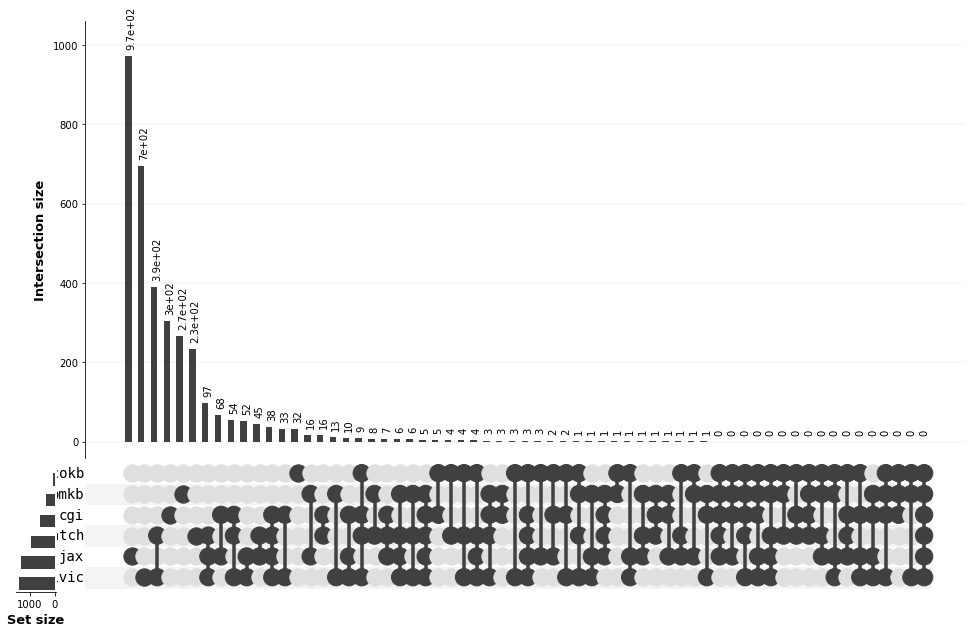

In [70]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(source_pmids)

Look at evidence levels from each source... OncoKB is "clinical only"--what does that mean?

Parse PMIDs specifically for each source, see if differences exist.

Connect PMIDs to genes, phenotypes, gene + phenotype